In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

# Load the breast cancer dataset
breast = load_breast_cancer()
df = pd.DataFrame(data=breast['data'], columns = breast['feature_names'])
df['target'] = breast.target
print(df.shape)
df.head()

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


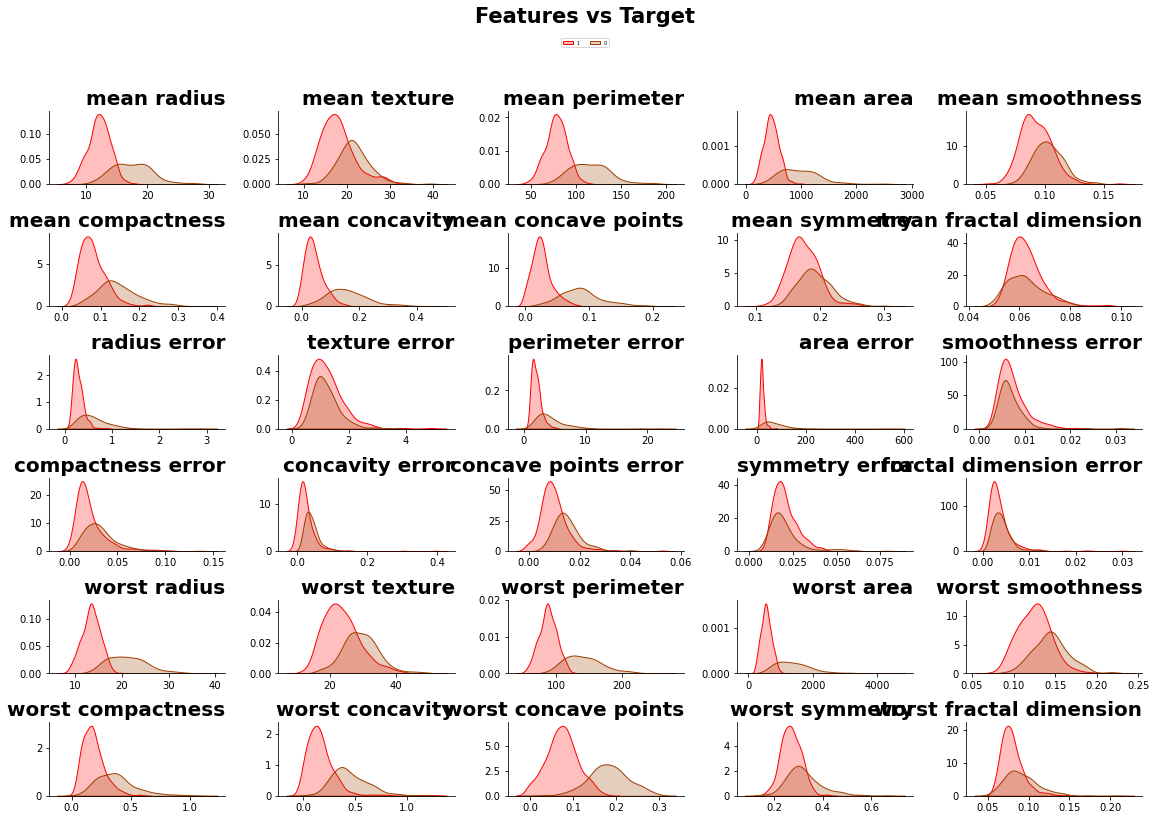

In [6]:
import seaborn as sns

num_cols = df.select_dtypes(include=['float64']).columns.tolist()

figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_cols):
    ax = plt.subplot(11,5, idx + 1)
    sns.kdeplot(
        data=df, hue='target', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=5, ncol=3)
plt.tight_layout()
plt.show()

In [7]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, RepeatedMultilabelStratifiedKFold

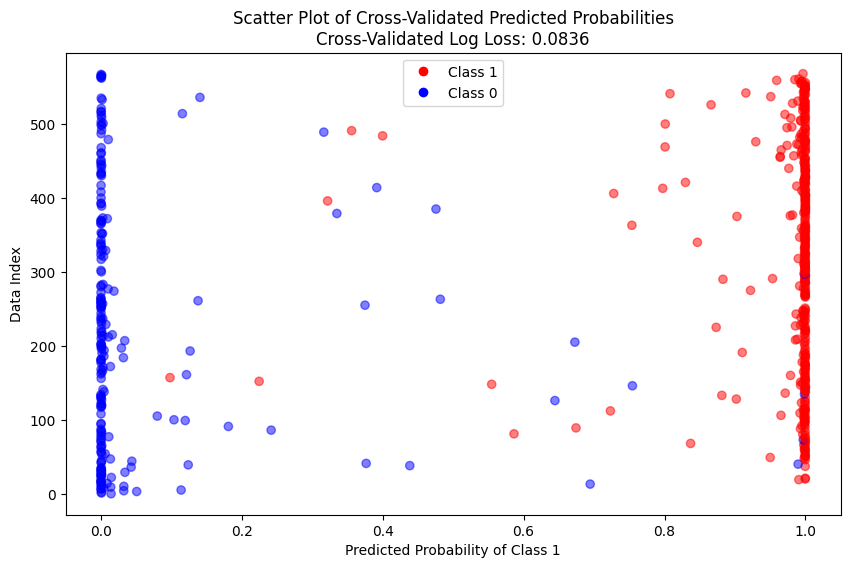

In [4]:
# Initialize the LGBM model
model = XGBClassifier()

# Perform cross-validation and get the predicted probabilities
y_pred = cross_val_predict(model, df.drop(columns=['target'], axis=1), df['target'], cv=5, method='predict_proba')

# Get the predicted probabilities for the positive class (class 1)
y_pred_class1 = y_pred[:, 1]

# Create the index array for the data points
indices = np.arange(len(df))

# Assign colors to different labels
colors = ['red' if label == 1 else 'blue' for label in df['target']]

# Calculate cross-validated log loss
loss = -np.mean(cross_val_score(model, df.drop(columns=['target'], axis=1), df['target'], cv=5, scoring='neg_log_loss'))

# Plot the scatter plot of predicted probabilities vs. data index with different colors
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_class1, indices, color=colors, alpha=0.5)
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Data Index')

# Create custom legend handles for the scatter plot
class1_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8)
class0_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8)
plt.legend([class1_patch, class0_patch], ['Class 1', 'Class 0'])

# Add cross-validated log loss to the title
plt.title(f'Scatter Plot of Cross-Validated Predicted Probabilities\nCross-Validated Log Loss: {loss:.4f}')
plt.show()

In [5]:
# (y_true = 1 and y_pred < 0.2) or (y_true = 0 and y_pred > 0.8) -> label 1
tgt2 = []
for i, j in zip(df['target'].ravel(), y_pred_class1):
    if (i==1 and j <0.2) or (i==0 and j>0.8):
        tgt2.append(1)
    else:
        tgt2.append(0)
tgt2 = np.array(tgt2)

In [7]:
X =  df.drop(columns=['target'], axis=1).values
tgt = df['target'].values

In [10]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras import regularizers as R
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import optimizers as O
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
tf.keras.utils.set_random_seed(722)

@tf.keras.utils.register_keras_serializable()
def smish(x):
    return x * K.tanh(K.log(1 + K.sigmoid(x)))


@tf.keras.utils.register_keras_serializable()
class GatedLinearUnit(L.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.linear = L.Dense(units)
        self.sigmoid = L.Dense(units, activation="sigmoid")
        self.units = units

    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        return config
    
    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)
    

@tf.keras.utils.register_keras_serializable()
class GatedResidualNetwork(L.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        self.relu_dense = L.Dense(units, activation=smish)
        self.linear_dense = L.Dense(units)
        self.dropout = L.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = L.LayerNormalization()
        self.project = L.Dense(units)

    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        return config
    
    def call(self, inputs):
        x = self.relu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x
    

@tf.keras.utils.register_keras_serializable()
class VariableSelection(L.Layer):
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.grns = list()
        # Create a GRN for each feature independently
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        # Create a GRN for the concatenation of all the features
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = L.Dense(units=num_features, activation="softmax")
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate

    def get_config(self):
        config = super().get_config()
        config['num_features'] = self.num_features
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        return config
    
    def call(self, inputs):
        v = L.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input_ in enumerate(inputs):
            x.append(self.grns[idx](input_))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs
    

@tf.keras.utils.register_keras_serializable()
class VariableSelectionFlow(L.Layer):
    def __init__(self, num_features, units, dropout_rate, dense_units=None, **kwargs):
        super().__init__(**kwargs)
        self.variableselection = VariableSelection(num_features, units, dropout_rate)
        self.split = L.Lambda(lambda t: tf.split(t, num_features, axis=-1))
        self.dense = dense_units
        if dense_units:
            self.dense_list = [L.Dense(dense_units, \
                                       activation='linear') \
                               for _ in tf.range(num_features)
                              ]
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate
        self.dense_units = dense_units
        
    def get_config(self):
        config = super().get_config()
        config['num_features'] = self.num_features
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        config['dense_units'] = self.dense_units
        return config        
    
    def call(self, inputs):
        split_input = self.split(inputs)
        if self.dense:
            l = [self.dense_list[i](split_input[i]) for i in range(len(self.dense_list))]
        else:
            l = split_input
        return self.variableselection(l)

In [18]:
%%time

from sklearn.metrics import log_loss
blls = []

batch_size = 32

units_1 = 32
drop_1 = 0.75
dense_units = 8

units_2 = 16
drop_2 = 0.5

units_3 = 8
drop_3 = 0.25

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=722)
for n, (train_idx, val_idx) in enumerate(cv.split(X, (tgt + 1) * (tgt2 - 3))):
    for k in range(10):
        print(f'______fold {n+1}______, ________repeat {k+1}__________')
        inputs_1 = tf.keras.Input(shape=(X.shape[1],))
        
        features_1 = VariableSelectionFlow(X.shape[1], units_1, drop_1, dense_units=dense_units)(inputs_1)
        features_2 = VariableSelectionFlow(units_1, units_2, drop_2)(features_1)         
        features_3 = VariableSelectionFlow(units_2, units_3, drop_3)(features_2)         

        outputs = L.Dense(1, activation="sigmoid")(features_3)

        model = Model(inputs=inputs_1, outputs=outputs)      

        opt = O.Adam(1e-3, epsilon=1e-7)
        loss = binary_crossentropy

        lr = ReduceLROnPlateau(monitor="val_loss", mode='min', factor=0.95, patience=1, verbose=1)
        es = EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1, restore_best_weights=True)

        model.compile(optimizer=opt, loss=loss)
        #tf.data.Dataset.from_tensor_slices((df.values, target.values))
        history = model.fit(x=X[train_idx], y=tgt[train_idx],
                          batch_size=batch_size,
                          epochs=30,
                          validation_data=(X[val_idx], tgt[val_idx]),
                          callbacks=[lr,es])
                
        probs = model.predict(X[val_idx])[:,0]
        bll = log_loss(tgt[val_idx], probs)
        blls.append(bll)
        val_loss = np.asarray(history.history['val_loss'])
        train_loss = np.asarray(history.history['loss'])
        min_val_loss = val_loss.min()
        min_train_loss = train_loss[val_loss.argmin()]
        print(f'{min_train_loss:.4f}, {min_val_loss:.4f}, {bll:.4f}')  
        
        #model.save_weights(f'/kaggle/working/ICR_tf_adv_models/mod_f{n}_r{k}_tr{min_train_loss:.4f}_val{min_val_loss:.4f}.h5')
        
print(np.mean(blls))

/Users/yukaisun/opt/anaconda3/envs/tabpfn/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


______fold 1______, ________repeat 1__________
Epoch 1/30
16/16 [==============================] - 152s 696ms/step - loss: 0.6554 - val_loss: 0.5987 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - 1s 79ms/step - loss: 0.4942 - val_loss: 0.3077 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - 1s 93ms/step - loss: 0.3398 - val_loss: 0.2428 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - ETA: 0s - loss: 0.2762
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
16/16 [==============================] - 1s 72ms/step - loss: 0.2762 - val_loss: 0.3106 - lr: 0.0010
Epoch 5/30
16/16 [==============================] - ETA: 0s - loss: 0.3134
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009025000152178108.
16/16 [==============================] - 1s 69ms/step - loss: 0.3134 - val_loss: 0.2687 - lr: 9.5000e-04
Epoch 6/30
16/16 [==============================] - ETA: 0s - loss: 0.2689
Epoch 6: ReduceLROnPlateau redu

KeyboardInterrupt: 